# Text Classification

- Pandas Documentation: http://pandas.pydata.org/
- Scikit Learn Documentation: http://scikit-learn.org/stable/documentation.html
- Seaborn Documentation: http://seaborn.pydata.org/
- Keras Documentation: https://keras.io


In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Text classification

Our goal is to perform a binary classification on text data. We will perform both a Spam detection example and a Sentiment analysis example. We will attempt 3 strategies:

1) build naive features based on our ideas

2) use well tested feature extraction technique

3) use deep learning and recurrent models on text

### 1. Spam detection on SMS messages

In [2]:
df = pd.read_csv('../data/sms.tsv', sep='\t')
df.head()

,label,msg
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df['label'].value_counts() / len(df)

ham     0.865937
spam    0.134063
Name: label, dtype: float64

### Exercise1: Encode Labels to 0 and 1

Create a variable called y that contains 0 for HAM messages and 1 for SPAM messages. There are several ways to do this.

In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

y = le.fit_transform(df['label'])

In [5]:
le.classes_

array(['ham', 'spam'], dtype=object)

In [6]:
y

array([0, 0, 1, ..., 0, 0, 0])

### Exercise 2: Build naive features based on keywords

- turn all your sms messages to lowercase
- define a function to count occurrences of a single keyword with the following signature:

        def count_word(word, sentence):
            ....
            return count_word_in_sentence
            
            
- to test your function, try it on these examples and check that the results match:
   
        count_word("the", "quick brown fox") # -> 0
        count_word("fox", "quick brown fox") # -> 1
        count_word("a", "a b a abab") # -> 2
     

- using the function `count_word` you just wrote, create a feature matrix `X` using counts of some keywords of your choice. (this will a bag-of-words representation.)
- create other similar features. You could use:
    - the length of the message
    - the presence of numbers
    - the presence of special characters
    - ...

In [7]:
docs = df['msg'].values

In [8]:
docs_lower = [d.lower() for d in docs]

In [9]:
def count_word(word, sentence):
    tokens = sentence.split()
    return len([w for w in tokens if w == word])

In [10]:
X = pd.DataFrame([count_word('free', d) for d in docs_lower], columns=['free'])

In [11]:
for keyword in ['win', 'discount', 'call']:
    X[keyword] = [count_word(keyword, d) for d in docs_lower]

In [12]:
import re

In [13]:
def count_numbers(sentence):
    return len(re.findall('[0-9]', sentence))

In [14]:
X['num_char'] = [count_numbers(d) for d in docs_lower]

In [15]:
X.head()

,free,win,discount,call,num_char
0,0,0,0,0,0
1,0,0,0,0,0
2,1,1,0,0,25
3,0,0,0,0,0
4,0,0,0,0,0


### Exercise 3: Train first model and evaluate performance

- split data in to train and test sets with `test_size=0.3, random_state=0`. you can use the `train_test_split` function from sklearn, which we have used in previous labs
- train model of your choice on these features
- evaluate performance on training and test set
- discuss with classmate:
    - how did you evaluate performance?
    - is model overfitting?
    - is model better than benchmark?

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.3, random_state=0)

In [18]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
model = RandomForestClassifier(n_estimators=100, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [20]:
model.score(X_train, y_train)

0.9766666666666667

In [21]:
model.score(X_test, y_test)

0.97188995215311

In [22]:
pd.Series(y_test).value_counts() / len(y_test)

0    0.867823
1    0.132177
dtype: float64

### Exercise 4: Cross Validation

- perform a 5-Fold cross validation on your model. you can refer back to lab 8 to refresh your memory on how to do this.
- print the confusion matrix and the classification report on the test data

In [23]:
from sklearn.model_selection import cross_val_score

In [24]:
scores = cross_val_score(model, X, y, cv = 5, n_jobs=-1)
scores

array([0.9793722 , 0.97399103, 0.96947935, 0.96858169, 0.97666068])

In [25]:
print("Average score: {:0.3} +/- {:0.3}".format(scores.mean(), scores.std()))

Average score: 0.974 +/- 0.00412


In [26]:
from sklearn.metrics import confusion_matrix, classification_report

In [27]:
y_pred = model.predict(X_test)

In [28]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.98      0.99      0.98      1451
          1       0.93      0.86      0.89       221

avg / total       0.97      0.97      0.97      1672



In [29]:
cm = confusion_matrix(y_test, y_pred)

pd.DataFrame(cm,
             index=['ham', 'spam'],
             columns=['pred_ham', 'pred_spam'])

,pred_ham,pred_spam
ham,1436,15
spam,32,189


### Exercise 5: Count Features

- use features based on word counts using the `CountVectorizer` class from Scikit Learn
- use the following function to simplify your code (it encapsulates model training and evaluation):


    def split_fit_eval(X, y, model=None, epochs=10, random_state=0):
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)

        if not model:
            model = Sequential()
            model.add(Dense(1, input_dim=X.shape[1], activation='sigmoid'))

            model.compile(loss='binary_crossentropy',
                          optimizer='adam',
                          metrics=['accuracy'])

        h = model.fit(X_train, y_train, epochs=epochs, verbose=1)

        train_loss, train_acc = model.evaluate(X_train, y_train)
        test_loss, test_acc = model.evaluate(X_test, y_test)

        return train_loss, train_acc, test_loss, test_acc, model, h


- did you improve the performance?

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

In [31]:
vocab_size = 3000

In [32]:
vect = CountVectorizer(decode_error='ignore',
                       stop_words='english',
                       lowercase=True,
                       max_features=vocab_size)

In [33]:
X = vect.fit_transform(docs)

In [34]:
Xd = X.todense()

In [35]:
vocab = vect.get_feature_names()

In [36]:
vocab[:10]

['00',
 '000',
 '02',
 '0207',
 '02073162414',
 '03',
 '04',
 '05',
 '06',
 '07123456789']

In [37]:
vocab[-10:]

['yogasana', 'yor', 'yr', 'yrs', 'yummy', 'yun', 'yunny', 'yuo', 'yup', 'zed']

In [38]:
from keras.layers import Dense
from keras.models import Sequential

Using TensorFlow backend.


In [39]:
def split_fit_eval(X, y, model=None, epochs=10, random_state=0):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)
    
    if not model:
        model = Sequential()
        model.add(Dense(1, input_dim=X.shape[1], activation='sigmoid'))

        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    
    h = model.fit(X_train, y_train, epochs=epochs, verbose=1)
    
    train_loss, train_acc = model.evaluate(X_train, y_train)
    test_loss, test_acc = model.evaluate(X_test, y_test)
    
    return train_loss, train_acc, test_loss, test_acc, model, h

In [40]:
res = split_fit_eval(Xd, y)

Epoch 1/10
4179/4179 [==============================] - 2s 366us/step - loss: 0.6250 - acc: 0.8595
Epoch 2/10
4179/4179 [==============================] - 0s 119us/step - loss: 0.4965 - acc: 0.9598
Epoch 3/10
4179/4179 [==============================] - 1s 123us/step - loss: 0.4078 - acc: 0.9675
Epoch 4/10
4179/4179 [==============================] - 0s 118us/step - loss: 0.3442 - acc: 0.9701
Epoch 5/10
4179/4179 [==============================] - 0s 118us/step - loss: 0.2968 - acc: 0.9725
Epoch 6/10
4179/4179 [==============================] - 1s 120us/step - loss: 0.2602 - acc: 0.9749
Epoch 7/10
4179/4179 [==============================] - 1s 120us/step - loss: 0.2312 - acc: 0.9775
Epoch 8/10
4179/4179 [==============================] - 0s 119us/step - loss: 0.2077 - acc: 0.9789
Epoch 9/10
4179/4179 [==============================] - 1s 121us/step - loss: 0.1882 - acc: 0.9801
Epoch 10/10
1393/1393 [==============================] - 0s 52us/step


In [41]:
res[1]

0.9818138311599025

In [42]:
res[3]

0.9777458722182341

## Sentiment Analysis

The previous dataset was easy. Let's switch to a harder one and do sentiment analysis on it.

In [43]:
df = pd.read_csv('../data/rt_critics.csv')
df.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
0,Derek Adams,fresh,114709.0,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559.0,Toy story
1,Richard Corliss,fresh,114709.0,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559.0,Toy story
2,David Ansen,fresh,114709.0,Newsweek,A winning animated feature that has something ...,2008-08-18,9559.0,Toy story
3,Leonard Klady,fresh,114709.0,Variety,The film sports a provocative and appealing st...,2008-06-09,9559.0,Toy story
4,Jonathan Rosenbaum,fresh,114709.0,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559.0,Toy story


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14072 entries, 0 to 14071
Data columns (total 8 columns):
critic         13382 non-null object
fresh          14072 non-null object
imdb           14072 non-null float64
publication    14072 non-null object
quote          14072 non-null object
review_date    14072 non-null object
rtid           14072 non-null float64
title          14072 non-null object
dtypes: float64(2), object(6)
memory usage: 879.6+ KB


In [45]:
df['fresh'].value_counts() / len(df)

fresh     0.612067
rotten    0.386299
none      0.001634
Name: fresh, dtype: float64

In [46]:
df = df[df.fresh != 'none'].copy()
df['fresh'].value_counts() / len(df)

fresh     0.613069
rotten    0.386931
Name: fresh, dtype: float64

In [47]:
y = le.fit_transform(df['fresh'])

### Exercise 6: TFIDF

- Build features with word frequencies (Tfidf). (sklearn has a preprocessor for this.)
- do train/test split
- train and evaluate a model

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [49]:
vect = TfidfVectorizer(decode_error='ignore',
                       stop_words='english',
                       max_features=20000)

X = vect.fit_transform(df['quote'])

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

In [51]:
model = RandomForestClassifier(n_estimators=100, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [52]:
model.score(X_train, y_train)

0.9997966239576977

In [53]:
model.score(X_test, y_test)

0.7098457888493476

### Exercise 7: NLP with deep learning

- Use the Tokenizer from Keras to:
    - Create a vocabulary
    - Convert sentences to sequences of integers
- pad the sequences so that they look like a tensor using the pad_sequences function from Keras.

In [54]:
from keras.preprocessing.text import Tokenizer

In [55]:
tokenizer = Tokenizer(num_words=20000)

docs = df['quote']
tokenizer.fit_on_texts(docs)
sequences = tokenizer.texts_to_sequences(docs)

- check max word index
- check max sequence length

In [56]:
max_features = max([max(seq) for seq in sequences if len(seq) > 0]) + 1
max_features

20000

In [57]:
maxlen = max([len(seq) for seq in sequences])
maxlen

49

In [58]:
from keras.preprocessing.sequence import pad_sequences

In [59]:
X = pad_sequences(sequences, maxlen=maxlen)

### Train / Test split on sequences

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

### Exercise 8: Build recurrent neural network model
- use what you have learned to build a recurrent model that classifies the sentiment

In [61]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding
from keras.layers import LSTM, GRU

In [62]:
model = Sequential()
model.add(Embedding(input_dim=max_features,
                    output_dim=32,
                    input_length=maxlen))
model.add(LSTM(32))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [63]:
h = model.fit(X_train, y_train, batch_size=64, epochs=4, validation_split=0.1)

Train on 8850 samples, validate on 984 samples
Epoch 1/4
8850/8850 [==============================] - 17s 2ms/step - loss: 0.6371 - acc: 0.6282 - val_loss: 0.5694 - val_acc: 0.7358
Epoch 2/4
8850/8850 [==============================] - 16s 2ms/step - loss: 0.4095 - acc: 0.8269 - val_loss: 0.5192 - val_acc: 0.7530
Epoch 3/4
8850/8850 [==============================] - 16s 2ms/step - loss: 0.2161 - acc: 0.9214 - val_loss: 0.6281 - val_acc: 0.7500
Epoch 4/4
8850/8850 [==============================] - 16s 2ms/step - loss: 0.1186 - acc: 0.9614 - val_loss: 0.6838 - val_acc: 0.7307


In [64]:
model.evaluate(X_train, y_train, batch_size=32)


9834/9834 [==============================] - 11s 1ms/step


[0.136187762064446, 0.9560707748869655]

In [65]:
loss, acc = model.evaluate(X_test, y_test, batch_size=32)
acc

4215/4215 [==============================] - 5s 1ms/step


0.7357058126448454

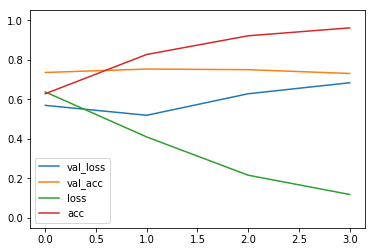

In [66]:
pd.DataFrame(h.history).plot(ylim=(-0.05, 1.05))

### Exercise 9

- Try changing the network architecture and re-train the model at each change. Can you avoid overfitting?
    - change the number of nodes in the LSTM layer
    - change the output dimension of the Embedding layer
    - add dropout and recurrent dropout to the LSTM
    - add a second LSTM layer
    - add kernel regularizers